<a href="https://colab.research.google.com/github/NikolasGialitsis/GrowthCurveCovid19/blob/master/Gialitsis_GrowthCurveCovid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

========================================================
========================================================
## Machine Learning Methods in Computational Biology  22/3/2020
### Assignment 1 
### @Author Gialitsis Nikos DS2.0005
========================================================
========================================================
----------------------------------------------------------------

Task (100  points): identify  the optimal model  from  a given simple parametric  family (polynomials  of  degree  up  to  M=9 as in Bishop’s book)  that  best  characterizes  the growth curve of COVID-19 cases without overfitting the data(using Occam’s razor principle). You should use time series data for different countries,including (but not limited to) 
China, SouthKorea, Japan,Italy, Spain,  France, UK, Germany, Netherlands,USA,Greece. 

To train candidate models for a country, you can use a proportion(say 2/3) of randomly selected data points for days up to date X= March 20, 2020. Then you can test the models’ performance using the rest of the data points not used for the training. The model that minimizes the test set  error is considered optimal. You may use the BIC criterion for model selection.  After the optimal model has been determined, you should also test its future predictions for the cases beyond date X. Date X should be a parameter,so that you can reuse your code to produce results considering any date beyond March 20, 2020 as date X. Of course, growth curves of the cases are not enough to show how the pandemic is spreading since there is evidence that a lot  of infected people remain asymptomatic, spreading the virus without  knowing it, and  this  is  why strict  social  distancing  is  a survival  attitude.  How  could  someone  estimate  the actual number  of all cases  from  what  we  currently  measure (using  PCR-based tests)? Review  the  related literature and present your opinion (in no more than half page with a clear justification).

In [1]:
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from google.colab import drive
drive.mount('/content/drive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/Colab Notebooks/.kaggle/"
!kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
  0% 0.00/636k [00:00<?, ?B/s]
100% 636k/636k [00:00<00:00, 92.6MB/s]


In [2]:
!unzip /content/novel-corona-virus-2019-dataset.zip

Archive:  /content/novel-corona-virus-2019-dataset.zip
  inflating: COVID19_line_list_data.csv  
  inflating: COVID19_open_line_list.csv  
  inflating: covid_19_data.csv       
  inflating: time_series_covid_19_confirmed.csv  
  inflating: time_series_covid_19_confirmed_US.csv  
  inflating: time_series_covid_19_deaths.csv  
  inflating: time_series_covid_19_deaths_US.csv  
  inflating: time_series_covid_19_recovered.csv  


Import libraries

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import pandas as pd
from sklearn import datasets, linear_model
from random import sample 

Load timeseries data for all confirmed covid19 cases in various countries and drop uneccesary columns

In [0]:
confirmed_df = pd.read_csv('/content/time_series_covid_19_confirmed.csv')
confirmed_df = confirmed_df.drop(labels=['Province/State','Lat','Long'],axis='columns')

Plot Covid19 cases for a certain number of countries including China, SouthKorea, Japan,Italy, Spain,  France, UK, Germany, Netherlands,USA,Greece

In [0]:
dates = confirmed_df.columns[1:]
xaxis = np.arange(len(dates)).tolist()
cases = []

CountryCases = {}
countries_list = [
'China',
'SouthKorea',
'Japan',
'Italy',
'Spain',
'France',
'UK',
'Germany',
'Netherlands',
'USA',
'Greece'
]
for country in countries_list:
  c_df = confirmed_df[confirmed_df['Country/Region'] == country]  
  c_cases = []
  for d in dates:
    region_cases = np.array(c_df[d].tolist())
    c_cases.append(region_cases.sum())
  CountryCases[country] = c_cases

<Figure size 432x288 with 0 Axes>

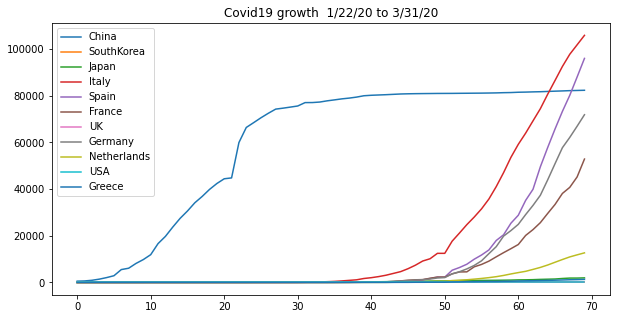

In [137]:
plt.figure(1)
fig, axes = plt.subplots(1,1, figsize=(10,5))
plt.title('Covid19 growth  '+str(dates[0]) + ' to '+str(dates[-1]))
for c in CountryCases.keys():
  plt.plot(xaxis,CountryCases[c],label= c)
plt.legend()
plt.show()


<Figure size 432x288 with 0 Axes>

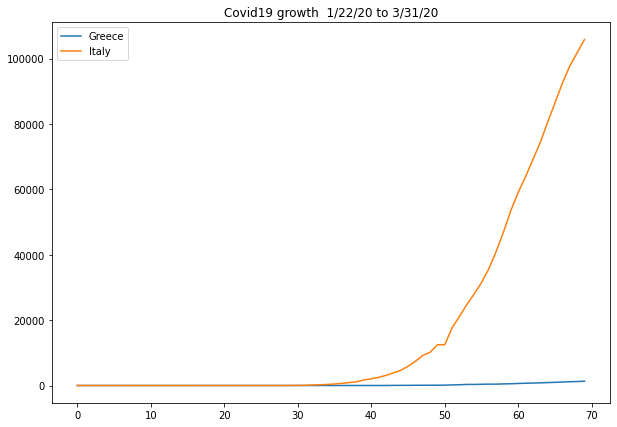

<Figure size 432x288 with 0 Axes>

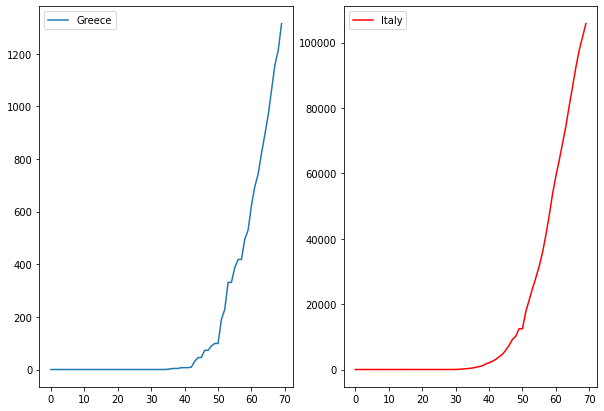

In [161]:
plt.figure(2)
fig, axes = plt.subplots(1,1, figsize=(10,7))
plt.title('Covid19 growth  '+str(dates[0]) + ' to '+str(dates[-1]))
for c in ['Greece','Italy']:
  plt.plot(xaxis,CountryCases[c],label= c)
plt.legend()
plt.show()


plt.figure(3)
fig, axes = plt.subplots(1,2, figsize=(10,7))
for c in ['Greece']:
  plt.subplot(121),
  plt.plot(xaxis,CountryCases[c],label= c)
  plt.legend()

for c in ['Italy']:
  plt.subplot(122),
  plt.plot(xaxis,CountryCases[c],label= c,color='r')
plt.legend()
plt.show()



In [0]:
x_all = CountryCases['Greece']
train_offset = round(0.8*len(x_all))
x_train = np.array(np.array(x_all)[:train_offset])
x_test = x_all[train_offset:].copy()
test_indices = np.arange(train_offset,len(x_all)).tolist()
assert(len(x_train) + len(x_test) == len(x_all))
assert(x_train[-1] != x_test[0])

indices = range(len(x_train))
train_indices = sample(list(indices),round(0.5*len(indices)))

test_indices.extend( [i for i in indices if i not in train_indices] )
x_test.extend( [x_train[i] for i in indices if i not in train_indices])
x_train = [x_train[i] for i in train_indices] 
assert(len(x_train) + len(x_test) == len(x_all))
assert(len(train_indices) ==  len(x_all) - len(test_indices) )


<Figure size 432x288 with 0 Axes>

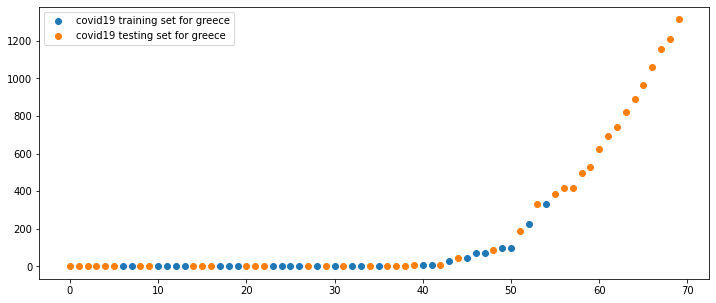

In [212]:
plt.figure(4)
fig, axes = plt.subplots(1,1, figsize=(12,5))
greece_train = CountryCases['Greece'][:train_offset]
greece_test = np.array(CountryCases['Greece'])[train_offset:]
plt.scatter(train_indices,x_train,label='covid19 training set for greece')
plt.scatter(test_indices,x_test,label= 'covid19 testing set for greece')
plt.legend()
plt.show()